In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  # "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

In [81]:
from utils import get_data
import warnings
warnings.filterwarnings("ignore")
quarterly_data, monthly_data, weekly_data, daily_data = get_data('2015-01-01', '9999-01-01')

In [82]:
# quarterly_data

In [83]:
df = pd.DataFrame()
# df['d_ln_avg_efficiency'] = quarterly_data['d_ln_avg_efficiency']
# df['d_ln_open_price'] = quarterly_data['d_ln_open_price']
df['d_ln_avg_efficiency'] = quarterly_data['ln_avg_efficiency']+12
df['d_ln_open_price'] = quarterly_data['ln_open_price']
# drop index
df = df.reset_index(drop=True)

In [84]:
test_size = 12
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]
print(len(train), len(test))

24 12


In [85]:
test

,d_ln_avg_efficiency,d_ln_open_price
24,7.466412,10.712867
25,7.725490,10.751486
26,8.041848,10.642423
27,7.955785,10.930841
28,7.764232,10.628157
29,7.857261,10.397204
30,7.964155,9.964038
31,7.798099,9.803642
32,8.129431,10.031204
33,7.992808,10.239864


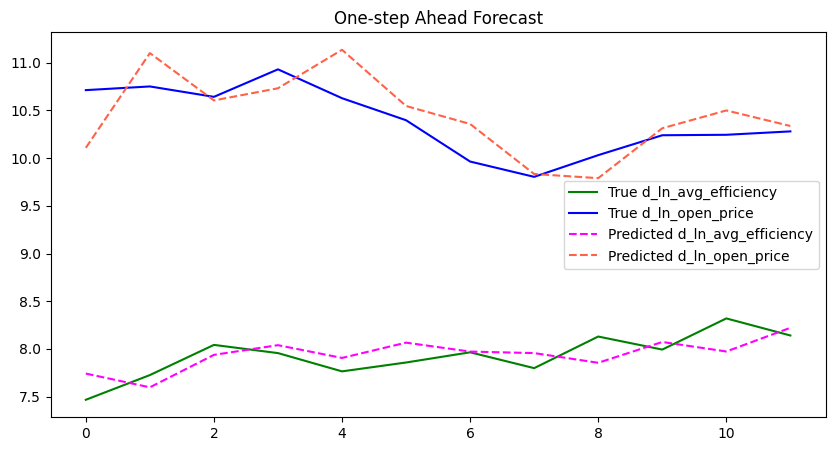

In [86]:
# Initialize context with training data
context1 = torch.tensor(train["d_ln_avg_efficiency"], dtype=torch.float32)  # Ensure the data type matches model requirements
context2 = torch.tensor(train["d_ln_open_price"], dtype=torch.float32)

# Lists to collect predictions
predictions_d_ln_avg_efficiency = []
predictions_d_ln_open_price = []

# Predict one step at a time
for i in range(len(test)):
    # Predict the next step
    forecast = pipeline.predict([context1, context2], prediction_length=1)  # Predicting only one step
    
    # Extract the median prediction for each series
    median_d_ln_avg_efficiency = np.quantile(forecast[0].numpy(), 0.5, axis=0)
    median_d_ln_open_price = np.quantile(forecast[1].numpy(), 0.5, axis=0)
    
    # Append the predictions
    predictions_d_ln_avg_efficiency.append(median_d_ln_avg_efficiency.item())  # Convert to Python scalar
    predictions_d_ln_open_price.append(median_d_ln_open_price.item())
    
    # Update the context with the true value for the next prediction
    # Note: This assumes test data is in the correct order and matches the context structure
    true_d_ln_avg_efficiency = test.iloc[i]["d_ln_avg_efficiency"]
    true_d_ln_open_price = test.iloc[i]["d_ln_open_price"]
    
    context1 = torch.cat([context1, torch.tensor([true_d_ln_avg_efficiency], dtype=torch.float32)])
    context2 = torch.cat([context2, torch.tensor([true_d_ln_open_price], dtype=torch.float32)])

# Convert predictions to numpy arrays for plotting
predictions_d_ln_avg_efficiency = np.array(predictions_d_ln_avg_efficiency)
predictions_d_ln_open_price = np.array(predictions_d_ln_open_price)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(test["d_ln_avg_efficiency"].values, label="True d_ln_avg_efficiency", color="green")
plt.plot(test["d_ln_open_price"].values, label="True d_ln_open_price", color="blue")
plt.plot(predictions_d_ln_avg_efficiency, label="Predicted d_ln_avg_efficiency", color="magenta", linestyle="--")
plt.plot(predictions_d_ln_open_price, label="Predicted d_ln_open_price", color="tomato", linestyle="--")
plt.legend()
plt.title("One-step Ahead Forecast")
plt.show()

In [87]:
print("average prediction error for d_ln_avg_efficiency: ", np.mean(np.abs(predictions_d_ln_avg_efficiency - test["d_ln_avg_efficiency"].values)))
print("average prediction error for d_ln_open_price: ", np.mean(np.abs(predictions_d_ln_open_price - test["d_ln_open_price"].values)))

average prediction error for d_ln_avg_efficiency:  0.15726990571564672
average prediction error for d_ln_open_price:  0.24142556488270164


In [88]:
# # context must be either a 1D tensor, a list of 1D tensors,
# # or a left-padded 2D tensor with batch as the first dimension
# context1 = torch.tensor(train["d_ln_avg_efficiency"])
# context2 = torch.tensor(train["d_ln_open_price"])
# context = [context1, context2]

In [89]:
# prediction_length = len(test)
# forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

In [90]:
# forecast.shape # torch.Size([2, prediction_length, prediction_length])

In [91]:
# # forecast_index = range(len(train), len(train) + prediction_length)
# forecast_index = range(len(test))
# low, median_d_ln_avg_efficiency, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
# low, median_d_ln_open_price, high = np.quantile(forecast[1].numpy(), [0.1, 0.5, 0.9], axis=0)

In [92]:
# # visualize the forecast
# plt.figure(figsize=(8, 4))
# plt.plot(np.array(df["d_ln_avg_efficiency"])[:len(test)], color="green", label="real d_ln_avg_efficiency")
# plt.plot(np.array(df["d_ln_open_price"])[:len(test)], color="blue", label="real d_ln_open_price")
# plt.plot(forecast_index, median_d_ln_avg_efficiency, color="magenta", label="median forecast")
# plt.plot(forecast_index, median_d_ln_open_price, color="tomato", label="median forecast")
# plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
# plt.legend()
# plt.grid()
# plt.show()